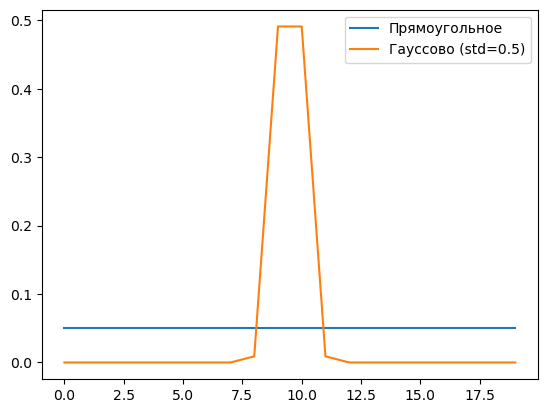

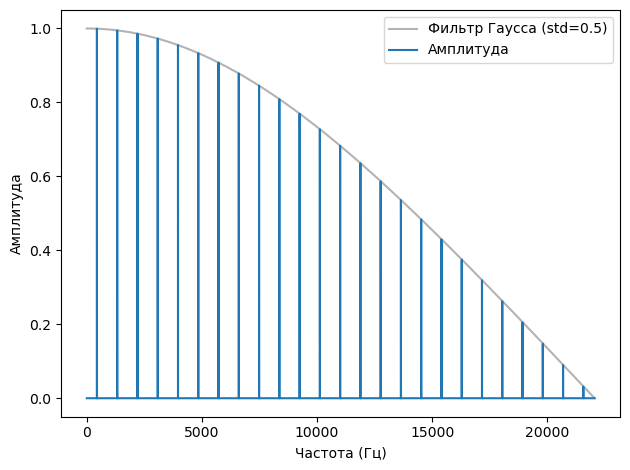

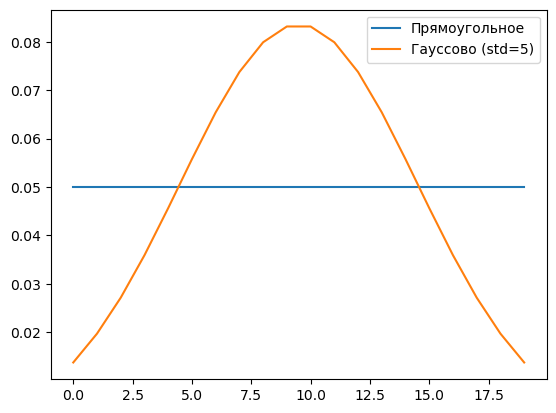

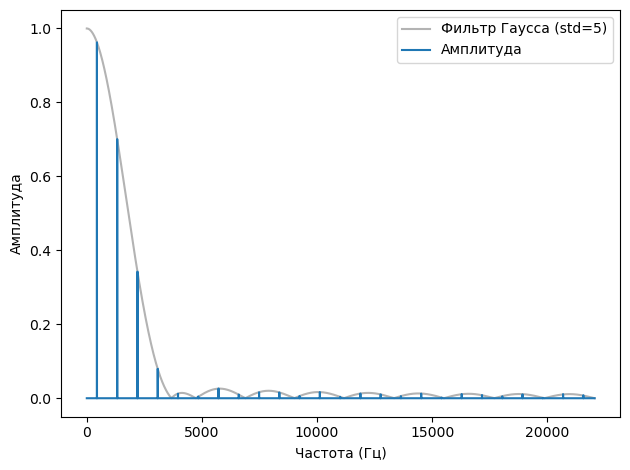

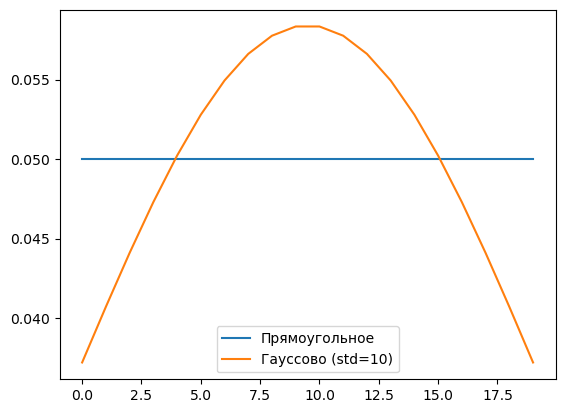

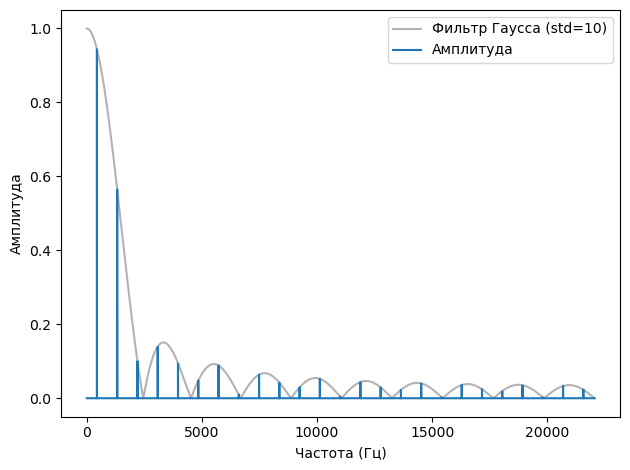

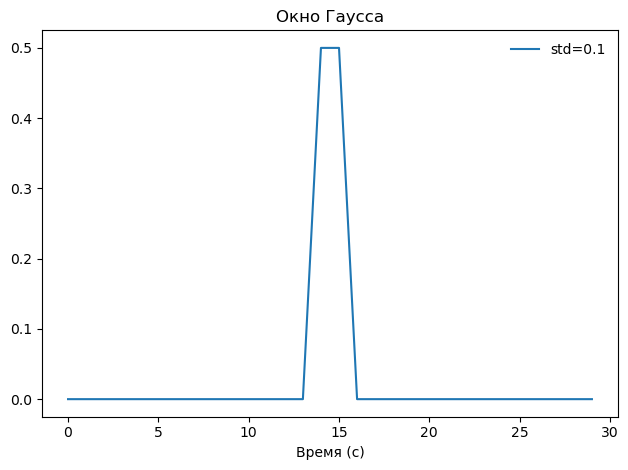

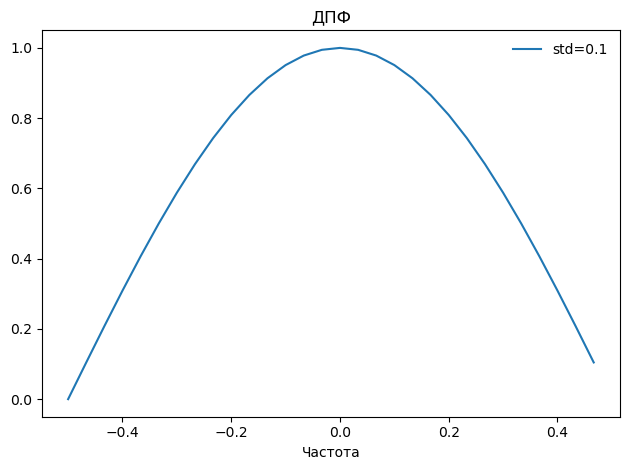

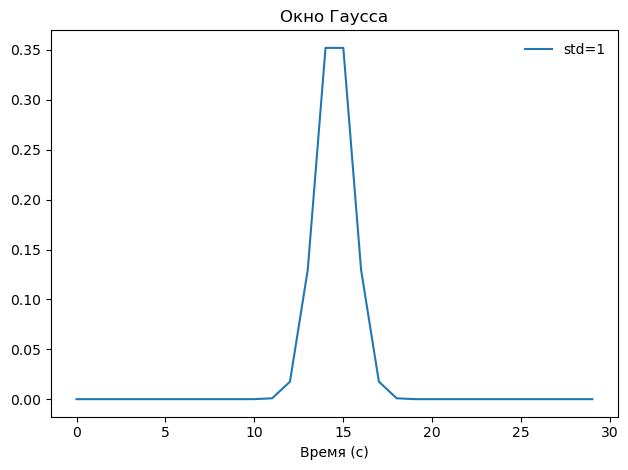

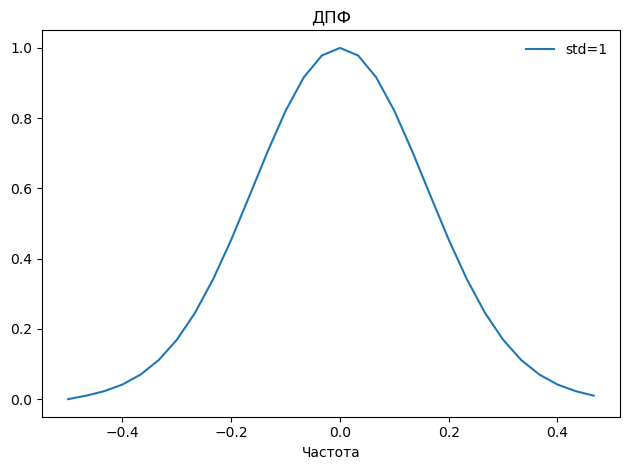

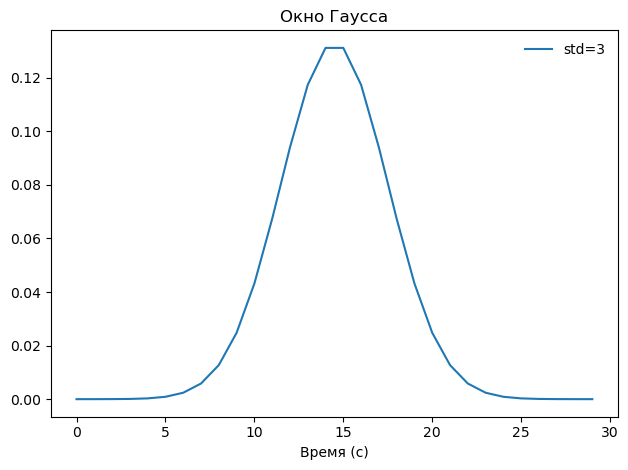

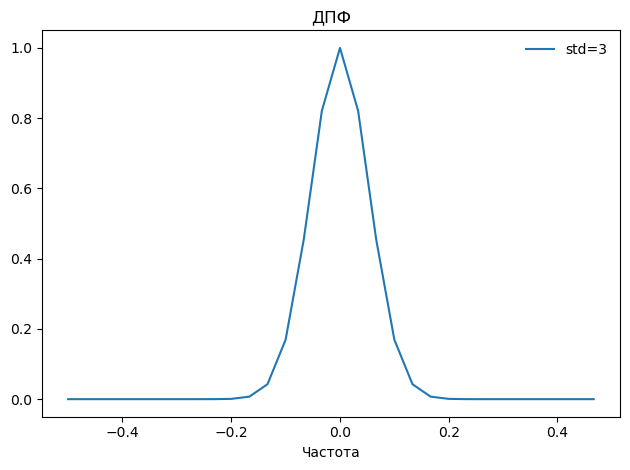

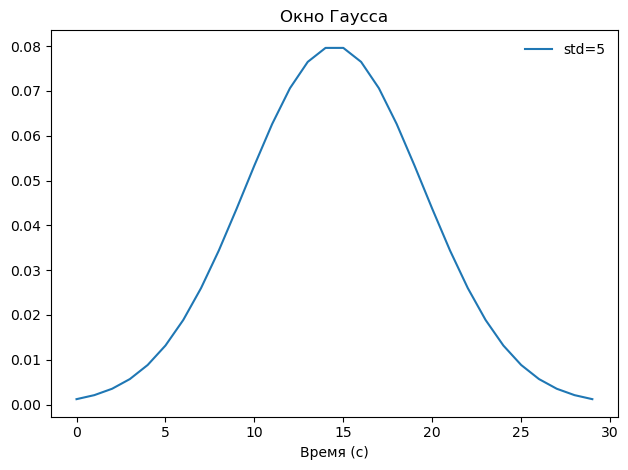

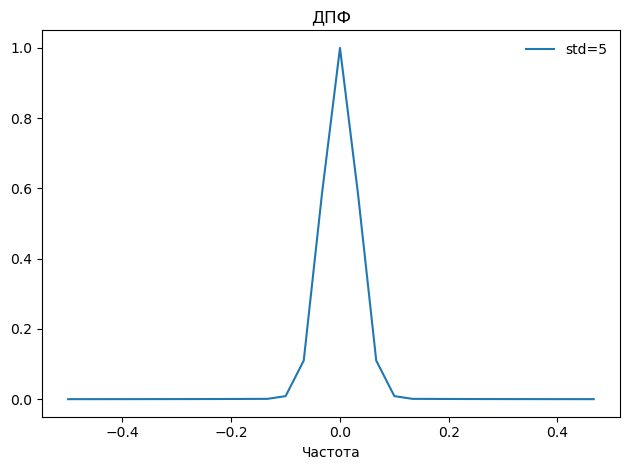

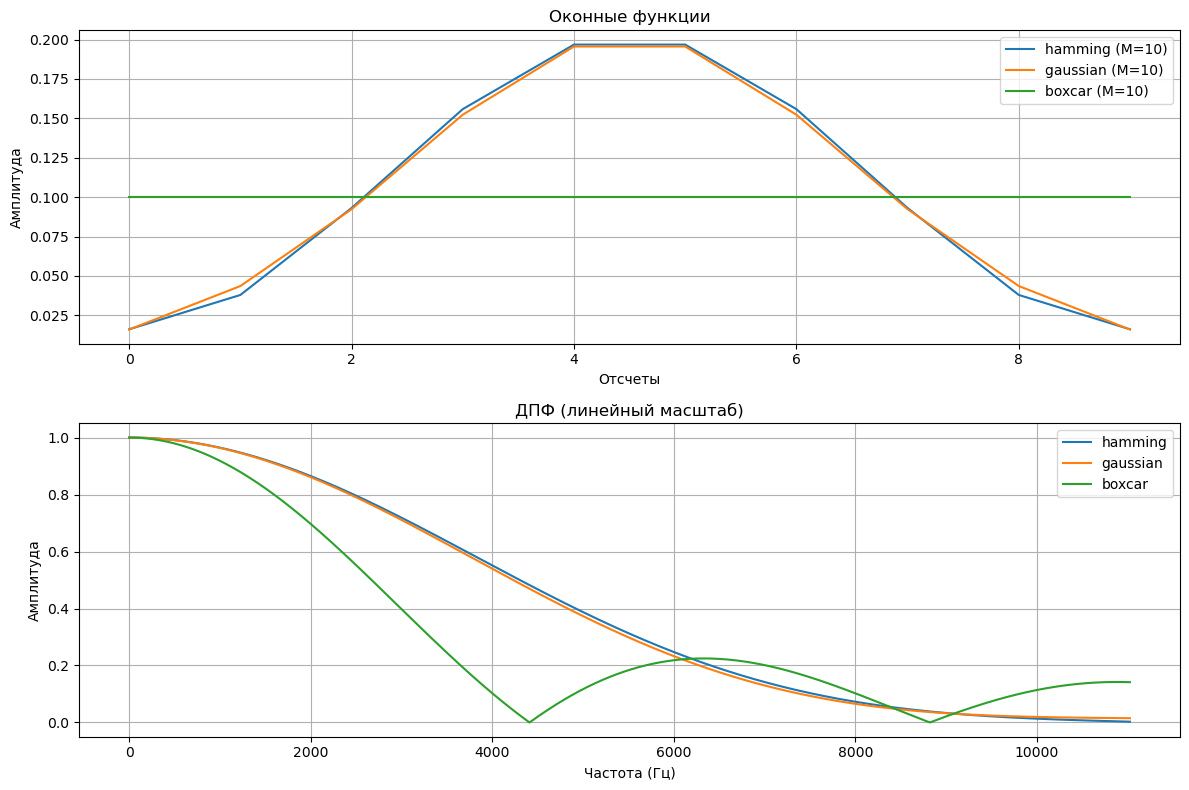

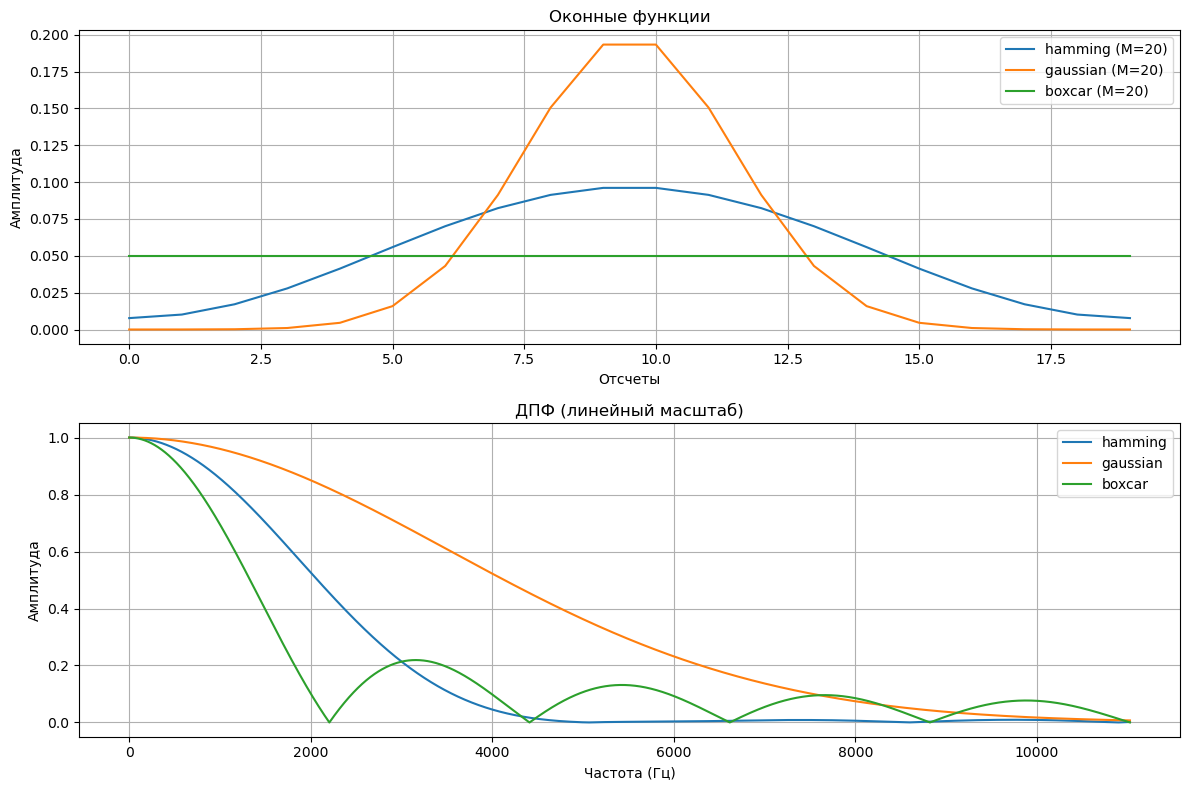

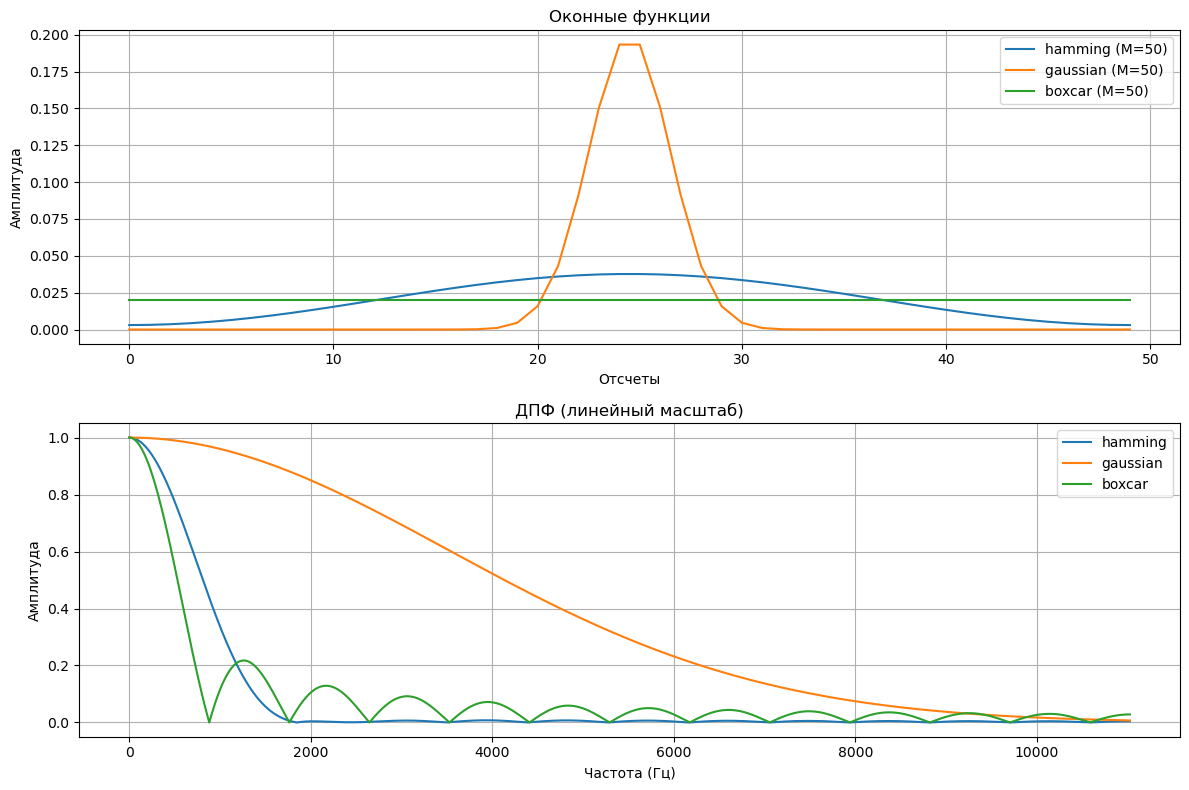

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import thinkplot
import scipy.signal
import ipywidgets as widgets
from thinkdsp import decorate, SquareSignal, Wave, zero_pad
from ipywidgets import interact, interactive, fixed

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

TWO_PI = 2 * np.pi

def generate_rect_filter(length=20):
    rect_kernel = np.ones(length)
    rect_kernel /= np.sum(rect_kernel)
    return rect_kernel

def generate_gauss_filter(length=20, deviation=2):
    gauss_kernel = scipy.signal.windows.gaussian(M=length, std=deviation)
    gauss_kernel /= np.sum(gauss_kernel)
    return gauss_kernel

def process_filter_and_display(signal_wave, filter_array, filter_name, amp_limit=560):
    filtered_data = np.convolve(signal_wave.ys, filter_array, mode='same')
    smoothed_wave = Wave(filtered_data, framerate=signal_wave.framerate)
    spec_original = signal_wave.make_spectrum()
    spec_smoothed = smoothed_wave.make_spectrum()
    amp_ratio = spec_smoothed.amps / spec_original.amps
    amp_ratio[spec_original.amps < amp_limit] = 0
    padded_filter = zero_pad(filter_array, len(signal_wave))
    dft_filter = np.fft.rfft(padded_filter)
    plt.plot(np.abs(dft_filter), color='0.7', label=f'Фильтр {filter_name}')
    plt.plot(amp_ratio, label='Амплитуда')

def examine_filters(dev_values=[0.5, 5, 10], window_size=20):
    rect_filter = generate_rect_filter(window_size)
    square_sig = SquareSignal(freq=440)
    wave_data = square_sig.make_wave(duration=1, framerate=44100)
    for dev in dev_values:
        gauss_filter = generate_gauss_filter(window_size, dev)
        plt.plot(rect_filter, label='Прямоугольное')
        plt.plot(gauss_filter, label=f'Гауссово (std={dev})')
        plt.legend()
        plt.show()
        process_filter_and_display(wave_data, gauss_filter, f'Гаусса (std={dev})')
        decorate(xlabel='Частота (Гц)', ylabel='Амплитуда')
        plt.legend()
        plt.show()

examine_filters()

def plot_gauss_profile(dev, size=30):
    gauss_profile = scipy.signal.windows.gaussian(M=size, std=dev)
    gauss_profile /= np.sum(gauss_profile)
    plt.plot(gauss_profile, label=f'std={dev}')
    decorate(xlabel='Время (с)', title='Окно Гаусса')
    plt.show()
    fft_result = np.fft.fft(gauss_profile)
    fft_shifted = np.fft.fftshift(fft_result)
    freq_points = np.fft.fftshift(np.fft.fftfreq(size))
    plt.plot(freq_points, np.abs(fft_shifted), label=f'std={dev}')
    decorate(xlabel='Частота', title='ДПФ')
    plt.show()
    return gauss_profile, fft_shifted

def study_profiles(dev_list=[0.1, 1, 3, 5], window_length=30):
    for dev in dev_list:
        gauss_profile, fft_shifted = plot_gauss_profile(dev, window_length)

study_profiles()

def investigate_window_types(window_options=['hamming', 'gaussian', 'boxcar'], 
                           length=30, deviation=2, duration=1.0, rate=44100):
    square_sig = SquareSignal(freq=440)
    wave_data = square_sig.make_wave(duration=duration, framerate=rate)
    plt.figure(figsize=(12, 8))
    for window_type in window_options:
        if window_type == 'gaussian':
            window_data = scipy.signal.windows.gaussian(M=length, std=deviation)
        elif window_type == 'hamming':
            window_data = np.hamming(length)
        elif window_type == 'boxcar':
            window_data = np.ones(length)
        else:
            continue
        window_data /= np.sum(window_data)
        padded_window = zero_pad(window_data, len(wave_data))
        dft_transform = np.fft.rfft(padded_window)
        freq_values = np.fft.rfftfreq(len(padded_window), 1/rate)
        plt.subplot(2, 1, 1)
        plt.plot(window_data, label=f'{window_type} (M={length})')
        decorate(title='Оконные функции', xlabel='Отсчеты', ylabel='Амплитуда')
        plt.legend()
        plt.grid(True)
        plt.subplot(2, 1, 2)
        plt.plot(freq_values[:len(dft_transform)//2], np.abs(dft_transform[:len(dft_transform)//2]), 
                 label=f'{window_type}')
        decorate(title='ДПФ (линейный масштаб)', xlabel='Частота (Гц)', ylabel='Амплитуда')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

for window_size in [10, 20, 50]:
    investigate_window_types(window_options=['hamming', 'gaussian', 'boxcar'], 
                           length=window_size, deviation=2)